In [37]:
import shapely
from shapely.geometry import Point
from shapely.geometry import LineString
from matplotlib import pyplot
%matplotlib inline
from copy import deepcopy
# function: plots one line (not a lineList) with first and last points with different colors
def plot_line(ax, line):
    #line = [(x, y),...]
    x, y = LineString(line).xy
    # plot lines between points
    ax.plot(x, y, color="#C885CD", alpha=0.7, linewidth=1, solid_capstyle='round', zorder=1)
    # Plot first and last points with different colors
    ax.plot(x[0], y[0], 'o', color='#80F222', zorder=2)
    ax.plot(x[-1], y[-1], 'o', color='#F22222', zorder=2)
    
# function: handle axes limits and title of a plot of a (lineList 
def handle_axesLimTitle_for_lineList(ax, lineList, title):
    #lineList = [line1, ...]
    allXList = []
    allYList = []
    for line in lineList:
        for point in line:
            allXList.append(point[0])
            allYList.append(point[1])
    XLim = [min(allXList), max(allXList)]
    YLim = [min(allYList), max(allYList)]
    XEmptySpace = int((XLim[1]-XLim[0])/5.0)
    YEmptySpace = int((YLim[1]-YLim[0])/5.0)
    if XEmptySpace == 0:
        XEmptySpace = 1
    if YEmptySpace == 0:
        YEmptySpace = 1
    Xrange = [int(XLim[0]) - XEmptySpace, int(XLim[1]) + XEmptySpace]
    Yrange = [int(YLim[0]) - YEmptySpace, int(YLim[1]) + YEmptySpace]
    ax.set_xlim(*Xrange)
    ax.set_ylim(*Yrange)
    # ax.set_yticks(list(range(*Yrange)) + [Yrange[-1]])
    # ax.set_aspect(1)
    ax.set_title(title) 

def lenLine(line):
    return Point(line[0]).distance(Point(line[1]))

def cosAndsine(line):
    # cos and sine made with horizon 
    cos = float(line[1][0] - line[0][0])/float(lenLine(line))
    sine = float(line[1][1] - line[0][1])/float(lenLine(line))
    return [cos, sine]
def vecLine(line):
    # line = [(,), (,)]
    # vec = [,]
    return [line[1][0] - line[0][0], line[1][1] - line[0][1]]

def crossAlmost(twoLineList):
    a = vecLine(twoLineList[0])
    b = vecLine(twoLineList[1])
    return a[0] * b[1] - a[1] * b[0]

def connectIfintesectedAlready(twoLineList, tolInt):
    lines = deepcopy(twoLineList)
    intrsct = LineString(lines[0]).intersection(LineString(lines[1]))
    for i in range(len(lines)):
        for j in range(len(lines[i])):
            if Point(lines[i][j]).distance(intrsct) < tolInt:
                lines[i][j] = (intrsct.x, intrsct.y)
    return lines

            
                


def closerTwoPointsIndex(twoLineList):
    line1 = twoLineList[0]
    line2 = twoLineList[1]
    distances = [Point(line1[0]).distance(Point(line2[0])), Point(line1[0]).distance(Point(line2[1])),
                 Point(line1[1]).distance(Point(line2[0])), Point(line1[1]).distance(Point(line2[1]))]

    min_dis = min(distances)

    minIndex = distances.index(min_dis)
    # info = [ [line1closepointindex, line1closecoordinates],
    #          [line2closepointindex, line2closecoordinates], mindistance, (avgX, avgY)]
    # it two lines are parallel 
    if minIndex == 0:
        info = [ [0, line1[0] ] , [0, line2[0]], min_dis]
        avgX = (line1[0][0] + line2[0][0])/float(2)
        avgY = (line1[0][1] + line2[0][1])/float(2)
        info.append((avgX, avgY))
    elif minIndex == 1:
        info = [ [0, line1[0] ] , [1, line2[1]], min_dis]
        avgX = (line1[0][0] + line2[1][0])/float(2)
        avgY = (line1[0][1] + line2[1][1])/float(2)
        info.append((avgX, avgY))
    elif minIndex == 2:
        info = [ [1, line1[1] ] , [0, line2[0]], min_dis]
        avgX = (line1[1][0] + line2[0][0])/float(2)
        avgY = (line1[1][1] + line2[0][1])/float(2)
        info.append((avgX, avgY))
    elif minIndex == 3:
        info = [ [1, line1[1] ] , [1, line2[1]], min_dis]
        avgX = (line1[1][0] + line2[1][0])/float(2)
        avgY = (line1[1][1] + line2[1][1])/float(2)
        info.append((avgX, avgY))
    return info

def extendTwoLinesFromClosePointSide(twoLineList, extL):
    info = closerTwoPointsIndex(twoLineList)
    lineListAfter = deepcopy(twoLineList)

    for i in range(len(lineListAfter)):
        
        extPoint = Point(info[i][1])
        otherPoint = Point(lineListAfter[i][abs(1-info[i][0])])

        cosT = cosAndsine(lineListAfter[i])[0]
        sinT = cosAndsine(lineListAfter[i])[1]
        extNewPoint = (extPoint.x + extL * cosT, extPoint.y + extL * sinT)
        if Point(extNewPoint).distance(otherPoint) < lenLine(lineListAfter[i]):
            extNewPoint = (extPoint.x - extL * cosT, extPoint.y - extL * sinT)
        
        lineListAfter[i][info[i][0]] = (extNewPoint[0], extNewPoint[1])
    return lineListAfter

def findDistancesFromIntersection(twoLineList, extL):
    info = closerTwoPointsIndex(twoLineList)
    lines = extendTwoLinesFromClosePointSide(twoLineList, extL)
    if LineString(lines[0]).intersects(LineString(lines[1])) == True:
        intrsct = LineString(lines[0]).intersection(LineString(lines[1]))
        firstLineDis = Point(info[0][1]).distance(intrsct)
        secLineDis = Point(info[1][1]).distance(intrsct)
        return [(intrsct.x, intrsct.y), firstLineDis, secLineDis]
    else:
        return "noInt"

def connectTointersectionIfTolSatisfied(twoLineList, extL, tolInt, tolClose):
    if LineString(twoLineList[0]).intersects(LineString(twoLineList[1])) == True:
        return connectIfintesectedAlready(twoLineList, tolInt)
    else:
        info = closerTwoPointsIndex(twoLineList)
        disFromInt = findDistancesFromIntersection(twoLineList, extL)
        lineListAfter = deepcopy(twoLineList)
        if disFromInt != "noInt" and max(disFromInt[1], disFromInt[2]) < tolInt:
            for i in range(len(lineListAfter)):
                lineListAfter[i][info[i][0]] = disFromInt[0]
            return lineListAfter
        elif info[2] < tolClose:
            for i in range(len(lineListAfter)):
                lineListAfter[i][info[i][0]] = info[3]
            return lineListAfter
        else: 
            return twoLineList


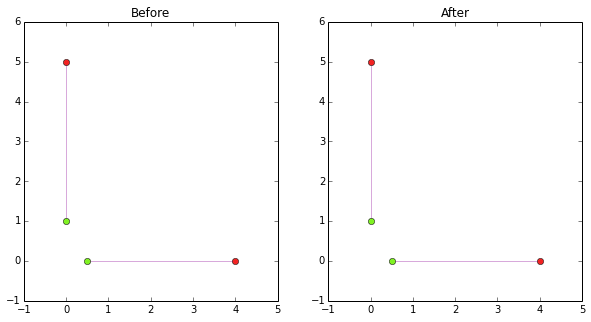

In [38]:
A = (0,1)
B = (0,5)
C = (0.5,0)
D = (4,0)

line1 = [A, B]
line2 = [C, D]
lineList =[line1, line2]

extL, tolInt, tolClose = 5, 1, 0.5
res = connectTointersectionIfTolSatisfied(lineList, extL, tolInt, tolClose)

fig = pyplot.figure(1, figsize=(10,5), dpi=90)
ax = fig.add_subplot(121)
for line in lineList:
    plot_line(ax, line)

handle_axesLimTitle_for_lineList(ax, lineList, "Before")
ax = fig.add_subplot(122)
for line in res:
    plot_line(ax, line)

handle_axesLimTitle_for_lineList(ax, lineList, "After")
pyplot.show()

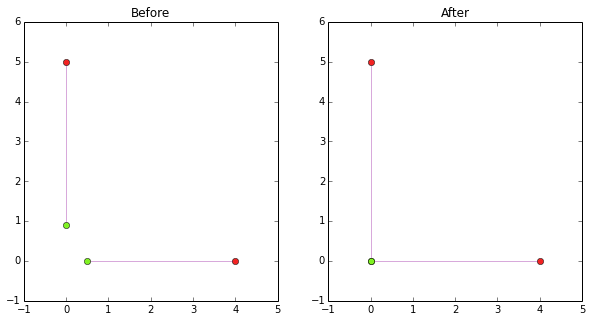

In [39]:
A = (0,0.9)
B = (0,5)
C = (0.5,0)
D = (4,0)

line1 = [A, B]
line2 = [C, D]
lineList =[line1, line2]

extL, tolInt, tolClose = 5, 1, 0.5
res = connectTointersectionIfTolSatisfied(lineList, extL, tolInt, tolClose)

fig = pyplot.figure(1, figsize=(10,5), dpi=90)
ax = fig.add_subplot(121)
for line in lineList:
    plot_line(ax, line)

handle_axesLimTitle_for_lineList(ax, lineList, "Before")
ax = fig.add_subplot(122)
for line in res:
    plot_line(ax, line)

handle_axesLimTitle_for_lineList(ax, lineList, "After")
pyplot.show()

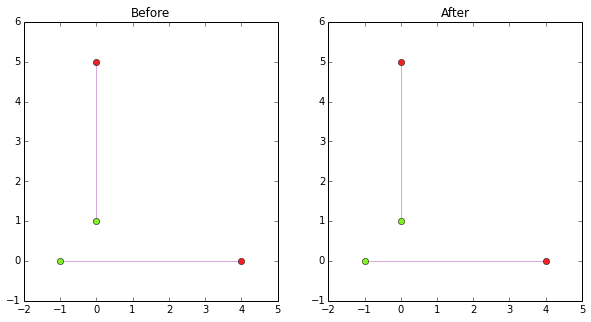

In [40]:
A = (0,1)
B = (0,5)
C = (-1,0)
D = (4,0)

line1 = [A, B]
line2 = [C, D]
lineList =[line1, line2]

extL, tolInt, tolClose = 5, 1, 0.5
res = connectTointersectionIfTolSatisfied(lineList, extL, tolInt, tolClose)

fig = pyplot.figure(1, figsize=(10,5), dpi=90)
ax = fig.add_subplot(121)
for line in lineList:
    plot_line(ax, line)

handle_axesLimTitle_for_lineList(ax, lineList, "Before")
ax = fig.add_subplot(122)
for line in res:
    plot_line(ax, line)

handle_axesLimTitle_for_lineList(ax, lineList, "After")
pyplot.show()

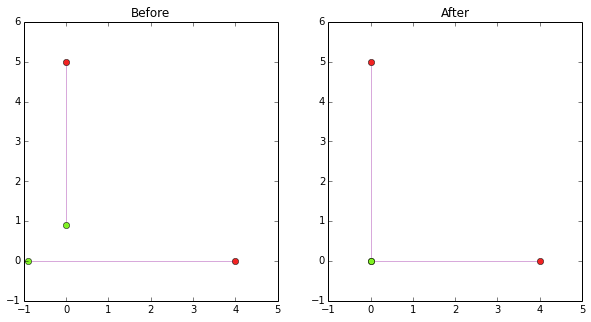

In [41]:
A = (0,0.9)
B = (0,5)
C = (-0.9,0)
D = (4,0)

line1 = [A, B]
line2 = [C, D]
lineList =[line1, line2]

extL, tolInt, tolClose = 5, 1, 0.5
res = connectTointersectionIfTolSatisfied(lineList, extL, tolInt, tolClose)

fig = pyplot.figure(1, figsize=(10,5), dpi=90)
ax = fig.add_subplot(121)
for line in lineList:
    plot_line(ax, line)

handle_axesLimTitle_for_lineList(ax, lineList, "Before")
ax = fig.add_subplot(122)
for line in res:
    plot_line(ax, line)

handle_axesLimTitle_for_lineList(ax, lineList, "After")
pyplot.show()

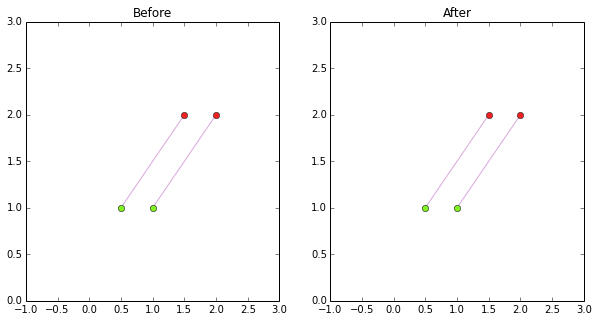

In [42]:
A = (1,1)
B = (2,2)
C = (0.5,1)
D = (1.5,2)

line1 = [A, B]
line2 = [C, D]
lineList =[line1, line2]

extL, tolInt, tolClose = 5, 1, 0.5
res = connectTointersectionIfTolSatisfied(lineList, extL, tolInt, tolClose)

fig = pyplot.figure(1, figsize=(10,5), dpi=90)
ax = fig.add_subplot(121)
for line in lineList:
    plot_line(ax, line)

handle_axesLimTitle_for_lineList(ax, lineList, "Before")
ax = fig.add_subplot(122)
for line in res:
    plot_line(ax, line)

handle_axesLimTitle_for_lineList(ax, lineList, "After")
pyplot.show()

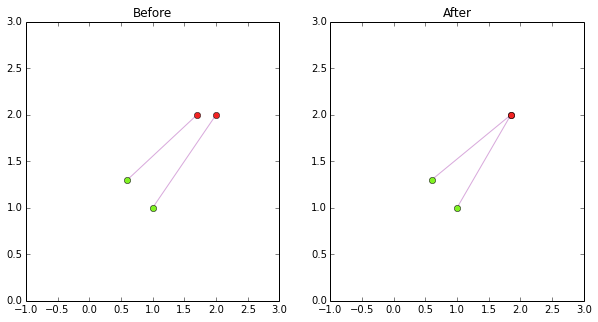

In [43]:
A = (1,1)
B = (2,2)
C = (0.6,1.3)
D = (1.7,2)

line1 = [A, B]
line2 = [C, D]
lineList =[line1, line2]

extL, tolInt, tolClose = 5, 0.5, 0.5
res = connectTointersectionIfTolSatisfied(lineList, extL, tolInt, tolClose)

fig = pyplot.figure(1, figsize=(10,5), dpi=90)
ax = fig.add_subplot(121)
for line in lineList:
    plot_line(ax, line)

handle_axesLimTitle_for_lineList(ax, lineList, "Before")
ax = fig.add_subplot(122)
for line in res:
    plot_line(ax, line)

handle_axesLimTitle_for_lineList(ax, lineList, "After")
pyplot.show()

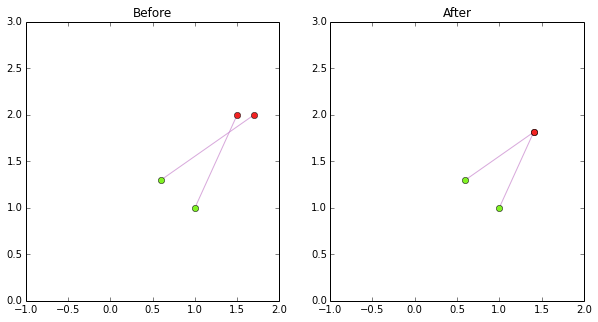

In [44]:
A = (1,1)
B = (1.5,2)
C = (0.6,1.3)
D = (1.7,2)

line1 = [A, B]
line2 = [C, D]
lineList =[line1, line2]

extL, tolInt, tolClose = 5, 0.5, 0.5
res = connectTointersectionIfTolSatisfied(lineList, extL, tolInt, tolClose)

fig = pyplot.figure(1, figsize=(10,5), dpi=90)
ax = fig.add_subplot(121)
for line in lineList:
    plot_line(ax, line)

handle_axesLimTitle_for_lineList(ax, lineList, "Before")
ax = fig.add_subplot(122)
for line in res:
    plot_line(ax, line)

handle_axesLimTitle_for_lineList(ax, lineList, "After")
pyplot.show()

[[(1, 1), (1.3636363636363635, 1.8727272727272726)], [(0.6, 1.3), (5, 4.6)]]
[[(1, 1), (1.5, 2.2)], [(0.6, 1.3), (5, 4.6)]]
[[(1, 1), (1.3636363636363635, 1.8727272727272726)], [(0.6, 1.3), (5, 4.6)]]


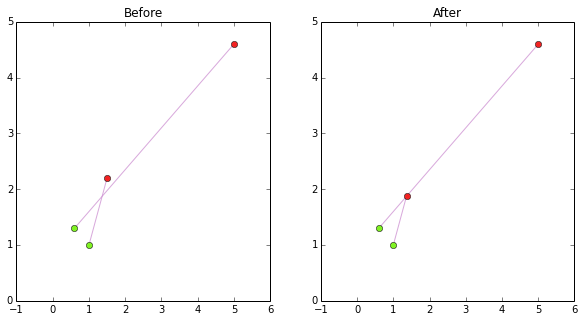

In [50]:
A = (1,1)
B = (1.5,2.2)
C = (0.6,1.3)
D = (5,4.6)

line1 = [A, B]
line2 = [C, D]
lineList =[line1, line2]

print connectIfintesectedAlready(lineList, 0.5)
print lineList

extL, tolInt, tolClose = 5, 0.5, 0.5
res = connectTointersectionIfTolSatisfied(lineList, extL, tolInt, tolClose)
print res

fig = pyplot.figure(1, figsize=(10,5), dpi=90)
ax = fig.add_subplot(121)
for line in lineList:
    plot_line(ax, line)

handle_axesLimTitle_for_lineList(ax, lineList, "Before")
ax = fig.add_subplot(122)
for line in res:
    plot_line(ax, line)

handle_axesLimTitle_for_lineList(ax, lineList, "After")
pyplot.show()